# Dataset : Student Dropout Dataset
### The dataset is from an indian state which contains informaton about students who dropped out and student who continue their study. We will consider dropout as anomly

#### 1. Load Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # To plot graphs
from sklearn.preprocessing import RobustScaler ## For data scaling
from sklearn.model_selection import train_test_split
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
import h2o

#### 2. Read Dataset

In [2]:
student_drop_out=pd.read_csv('studentDropIndia.csv')
student_drop_out.head()
student_drop_out_orig=student_drop_out

#### 3. Understanding data

In [3]:
student_drop_out.dtypes

continue_drop          object
student_id             object
gender                 object
caste                  object
mathematics_marks     float64
english_marks         float64
science_marks         float64
science_teacher         int64
languages_teacher       int64
guardian               object
internet                 bool
school_id               int64
total_students          int64
total_toilets         float64
establishment_year    float64
dtype: object

In [4]:
student_drop_out.shape

(19100, 15)

#### 4. Data Preprocessing

In [5]:
## list of columns which have NA data:
def find_column_na(dataframe,na_limit):
    dataframe_null_check = dataframe.isnull()
    dataframe_null_check_sum = dataframe_null_check.sum()
    columnlist=[]
    for i in range(0,len(dataframe_null_check_sum)):
        if(dataframe_null_check_sum[i]>na_limit):
            print(dataframe_null_check_sum.index[i],dataframe_null_check_sum[i])
            columnlist.append(dataframe.columns[i])
    return columnlist

In [6]:
## As a result, 2 numeric columns have 338 rows with NA data:
na_columns = find_column_na(student_drop_out,0)

total_toilets 338
establishment_year 338


In [7]:
## Since two colmns are total toilets and establishment year.
## Replacing with Zero to fill NA rows for these columns:
def replaceNumBlankwithZero(dataframe,columns):
    data_no_blank = dataframe
    for col in columns:
            data_no_blank[col].fillna(0, inplace=True)
    
    return data_no_blank

In [8]:
student_drop_out_no_na=replaceNumBlankwithZero(student_drop_out,na_columns)
student_drop_out_no_na.isnull().any()

continue_drop         False
student_id            False
gender                False
caste                 False
mathematics_marks     False
english_marks         False
science_marks         False
science_teacher       False
languages_teacher     False
guardian              False
internet              False
school_id             False
total_students        False
total_toilets         False
establishment_year    False
dtype: bool

In [9]:
## Extract sample from data:
student_drop_out_no_na.sample(10)

,continue_drop,student_id,gender,caste,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,guardian,internet,school_id,total_students,total_toilets,establishment_year
12535,drop,s12536,M,SC,0.685,0.662,0.685,4,2,mother,True,361,287,15.0,1992.0
11284,drop,s11285,M,BC,0.438,0.495,0.438,5,3,mother,True,374,207,28.0,1896.0
13917,continue,s13918,F,BC,0.523,0.594,0.523,0,7,mother,True,364,147,28.0,1911.0
7834,continue,s07835,M,BC,0.730,0.502,0.730,6,3,mother,False,334,571,61.0,1924.0
742,continue,s00743,F,BC,0.461,0.379,0.461,6,6,father,False,331,516,15.0,1996.0
1877,continue,s01878,F,SC,0.766,0.647,0.766,2,4,mother,True,324,170,31.0,1949.0
16613,continue,s16614,M,BC,0.562,0.530,0.562,8,5,father,True,327,251,18.0,1984.0
13106,continue,s13107,F,SC,0.684,0.848,0.684,8,6,father,True,362,397,5.0,1950.0
10758,continue,s10759,F,SC,0.417,0.535,0.417,3,7,father,False,343,353,15.0,1957.0
2556,continue,s02557,M,BC,0.558,0.573,0.558,1,4,mother,True,323,344,28.0,1961.0


In [10]:
## Standardizing numberic data with multiple scale range:
def find_numerical_col(dataframe):
    columnlist_num=[]
    #fig =  plt.figure(figsize=(10,10))
    for i in range(1,len(dataframe.columns)):
           if dataframe[dataframe.columns[i]].dtypes=='int64' or dataframe[dataframe.columns[i]].dtypes=='float64':
                    columnlist_num.append(dataframe.columns[i])
    return columnlist_num

def do_robustScaler(X):
    robust=RobustScaler()
    X_robust = robust.fit_transform(X)
    return X_robust

num_columns = find_numerical_col(student_drop_out_no_na)
student_drop_out_no_na_num_col=student_drop_out_no_na[num_columns]
# Let run robus scale function now to scale our numneric data
student_drop_out_no_na_num_col_scaled = do_robustScaler(student_drop_out_no_na_num_col)
# Return data is numpy array
type(student_drop_out_no_na_num_col_scaled)

numpy.ndarray

#### 5. String conversion to Numeric data for H20 Encoder

In [11]:
## firstly, drop the student id column
student_drop_out_no_na = student_drop_out_no_na.drop('student_id', 1)

In [12]:
## Find categorical columns
def find_categ_column(dataframe):
    return dataframe.select_dtypes(exclude=["number","bool_"]).columns

In [13]:
## five columns with string data types
cat_columns = find_categ_column(student_drop_out_no_na)

## Run getDummies function to encode categorical data
student_drop_out_no_na_dummy = pd.get_dummies(student_drop_out_no_na[cat_columns],columns = cat_columns)
student_drop_out_no_na_dummy.head()

,continue_drop_continue,continue_drop_drop,gender_F,gender_M,caste_BC,caste_OC,caste_SC,caste_ST,guardian_father,guardian_mixed,guardian_mother,guardian_other
0,1,0,1,0,0,0,1,0,0,0,1,0
1,1,0,1,0,1,0,0,0,0,0,1,0
2,1,0,1,0,0,1,0,0,0,0,1,0
3,1,0,1,0,1,0,0,0,0,0,1,0
4,1,0,1,0,0,1,0,0,0,0,0,1


In [14]:
## Convert scaled numpy numeric array to panda dataframe.
## Later, join it with encoded categorical dataframe:
scaled_data_df=pd.DataFrame(student_drop_out_no_na_num_col_scaled, columns=num_columns) 
scaled_data_df.head()

,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,school_id,total_students,total_toilets,establishment_year
0,-0.352159,-0.209677,-0.352159,0.50,-1.25,-0.790698,0.000000,0.928571,0.967213
1,-0.747508,-0.218894,-0.747508,0.00,0.50,-0.372093,0.454106,-0.071429,0.278689
2,0.289037,0.490783,0.289037,0.00,-0.75,-0.511628,-0.400966,-0.500000,0.475410
3,-0.455150,-0.154378,-0.455150,1.00,0.50,-0.906977,0.444444,5.071429,0.983607
4,0.069767,0.251152,0.069767,1.25,-0.25,0.372093,0.053140,-0.928571,1.131148


In [15]:
## join 2 data frame horizentally
X = pd.concat([scaled_data_df,student_drop_out_no_na_dummy],axis=1)
X.head()

,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,school_id,total_students,total_toilets,establishment_year,continue_drop_continue,...,gender_F,gender_M,caste_BC,caste_OC,caste_SC,caste_ST,guardian_father,guardian_mixed,guardian_mother,guardian_other
0,-0.352159,-0.209677,-0.352159,0.50,-1.25,-0.790698,0.000000,0.928571,0.967213,1,...,1,0,0,0,1,0,0,0,1,0
1,-0.747508,-0.218894,-0.747508,0.00,0.50,-0.372093,0.454106,-0.071429,0.278689,1,...,1,0,1,0,0,0,0,0,1,0
2,0.289037,0.490783,0.289037,0.00,-0.75,-0.511628,-0.400966,-0.500000,0.475410,1,...,1,0,0,1,0,0,0,0,1,0
3,-0.455150,-0.154378,-0.455150,1.00,0.50,-0.906977,0.444444,5.071429,0.983607,1,...,1,0,1,0,0,0,0,0,1,0
4,0.069767,0.251152,0.069767,1.25,-0.25,0.372093,0.053140,-0.928571,1.131148,1,...,1,0,0,1,0,0,0,0,0,1


#### 6. Split the dataset into training and test
###### Since all "dropouts" are being considered as anomly, keep all drop outs in test dataset along with 20% of "continue" dataset as test

In [17]:
print("Total number of Rows in data set")
print(X.shape[0])

X_nonanomly=X.loc[X['continue_drop_continue'] == 1]
print("Total number of Rows for non anomly data set")
print(X_nonanomly.shape[0])

Xtrain, Xtest = train_test_split(X_nonanomly,test_size=0.2)
print("Total number of Rows for non anomly train data set")
print(Xtrain.shape[0])
print("Total number of Rows for non anomly test data set")
print(Xtest.shape[0])

print("Total number of Rows for anomly data set")
test_anomly=X.loc[X['continue_drop_drop'] == 1]
print(test_anomly.shape[0])

Total number of Rows in data set
19100
Total number of Rows for non anomly data set
18200
Total number of Rows for non anomly train data set
14560
Total number of Rows for non anomly test data set
3640
Total number of Rows for anomly data set
900


In [18]:
## So this will give us Test data set and we will detect anomly in our test data set using H2O encoder
print("Total number of Rows for non anomly test data set and anomly test datset")
Xtest_anom=pd.concat([Xtest,test_anomly],axis=0)
print(Xtest_anom.shape[0])

Total number of Rows for non anomly test data set and anomly test datset
4540


#### 7.  visualize the anomly before we proceed to create the model to identify it

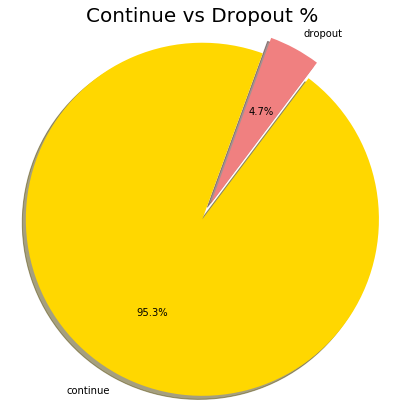

In [19]:
labels = ['continue', 'dropout']
sizes = [student_drop_out_no_na['continue_drop'].value_counts()['continue'],
         student_drop_out_no_na['continue_drop'].value_counts()['drop']
        ]
colors = ['gold','lightcoral']
explode = (0, 0.1)  # explode 1st slice
plt.figure(figsize=[7, 7])
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=70)
plt.title("Continue vs Dropout %",fontsize=20)
plt.axis('equal')
plt.show()

#### 8. Autoencoder and H20 Modelling

In [20]:
## Initiate H20 Encoder:
h2o.init(nthreads=-1, enable_assertions = False)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from C:\Users\shubhangi\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\shubhangi\AppData\Local\Temp\2\tmpfjqv19zi
  JVM stdout: C:\Users\shubhangi\AppData\Local\Temp\2\tmpfjqv19zi\h2o_shubhangi_started_from_python.out
  JVM stderr: C:\Users\shubhangi\AppData\Local\Temp\2\tmpfjqv19zi\h2o_shubhangi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,13 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_shubhangi_vf2pnb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [21]:
## convert panda dataframe to H2O dataframe
h2odf_train=h2o.H2OFrame(Xtrain)
h2odf_test=h2o.H2OFrame(Xtest_anom)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


###### use "Tanh" as a activation function with hidden layer neural network 15-->(5-->3-->5)-->15

In [22]:
## Configuring "Tanh" as a activation function with hidden layer neural network 15-->(5-->3-->5)-->15:
anomly_model = H2OAutoEncoderEstimator(activation="Tanh", 
                                hidden=[5,3,5], 
                                model_id="anomly_model",
                                ignore_const_cols=False, 
                                autoencoder=True,
                                epochs=100)

## List of predictors:
predictors=list(range(0,14))

## training Anomaly model:
anomly_model.train(x=predictors,training_frame=h2odf_train)

deeplearning Model Build progress: |████████████████████████████████████████| 100%


######  use anomly detection model on our test dataset and we will convert that dataset to dataframe.Then we will add one more column to our dataframe "id", so then we will get two columns "id" and "Reconstruction.MSE"

In [23]:
## Configure anomly detection model on our test dataset and we will convert that dataset to dataframe.Then we will add one more column to our dataframe "id", so then we will get two columns "id" and "Reconstruction.MSE":
detect_anomly = anomly_model.anomaly(h2odf_test)
detect_anomly = detect_anomly.as_data_frame()

detect_anomly['id'] = detect_anomly.index

#### 9.  Plotting the result of our test dataset

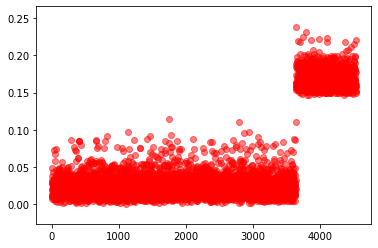

In [24]:
plt.scatter(x=detect_anomly['id'],y=detect_anomly['Reconstruction.MSE'], c='r', alpha=0.5)
plt.show()

#### 10. Student H20 Server

In [25]:
h2o.cluster().shutdown()

H2O session _sid_a271 closed.
